### 이미지 전처리

In [ ]:
!pip install matplotlib
!pip install opencv-python
!pip install scikit-image
!pip install tqdmp


In [ ]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
import math
from tqdm.notebook import tqdm
from skimage.morphology import skeletonize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
plt.rcParams['figure.figsize'] = (8,8)

In [ ]:
train_path = '/content/drive/MyDrive/생체/train/train_ref'
test2_path = '/content/drive/MyDrive/생체/test2/test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))

print(len(list_train), len(list_test2))

477 1428


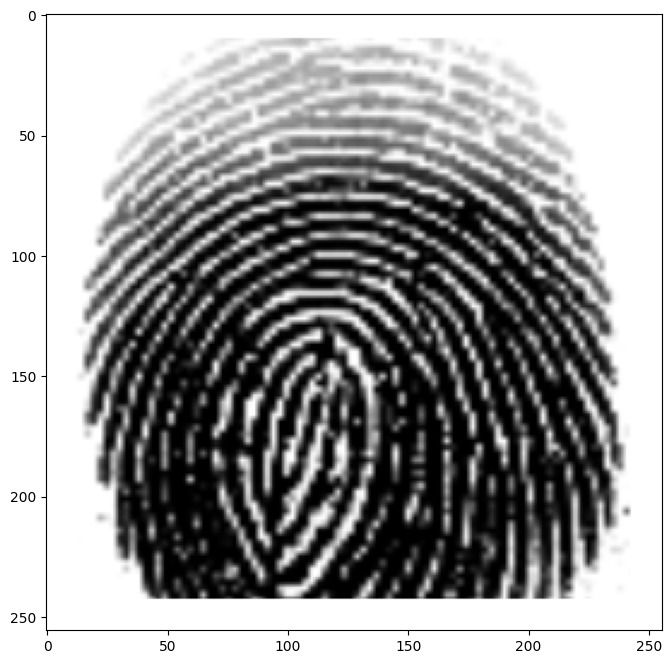

In [ ]:
img = cv2.imread(list_train[0],cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.show()

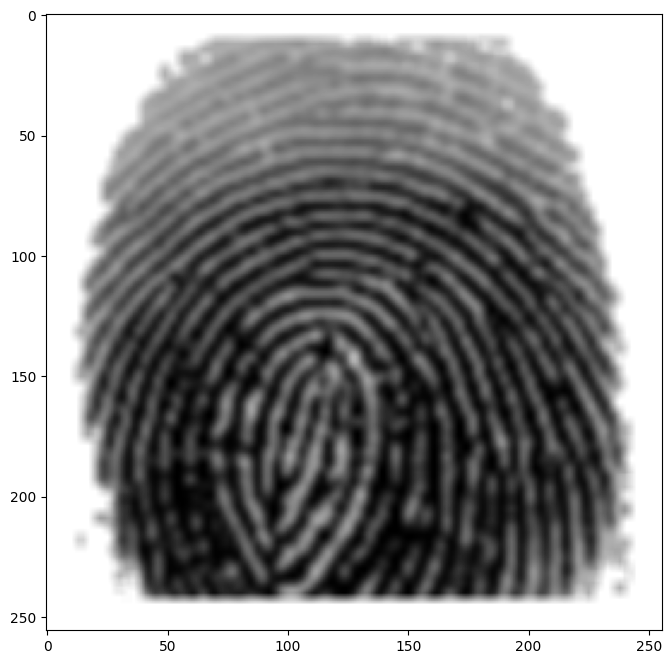

In [ ]:
def img_preprocessing(img, ks):

    # Normalize histogram
    normalized_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Apply histogram equalization to enhance contrast
    equalized_img = cv2.equalizeHist(normalized_img)

    kernel = np.ones((ks, ks), np.float32) / (ks * ks)

    # Apply custom kernel blurring
    blurred_img_custom_kernel = cv2.filter2D(equalized_img, -1, kernel)


    return blurred_img_custom_kernel


blur = img_preprocessing(img, 5)
plt.imshow(blur, cmap='gray')

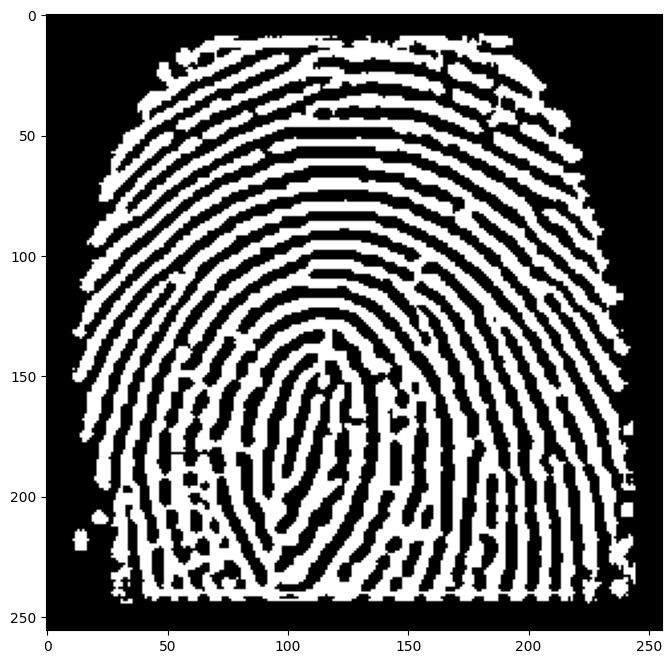

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def binarization(blur_img):
    # 전역 임계값 적용
    img_zero = np.zeros((256, 256), dtype=np.uint8)
    img_zero[blur_img < 80] = 255

    # 커널 사이즈와 패딩 계산
    kernel_size = 5
    pad_size = kernel_size // 2

    # 이미지를 패딩하여 가장자리 문제 해결
    padded_img = np.pad(blur_img, pad_size, mode='constant', constant_values=0)

    # 이진화된 이미지를 저장할 배열 생성
    binary_image = np.zeros_like(blur_img, dtype=np.uint8)

    # 커널을 사용하여 이미지 스캔 및 적응형 임계값 적용
    for i in range(blur_img.shape[0]):
        for j in range(blur_img.shape[1]):
            # 현재 픽셀을 중심으로 하는 커널 추출
            kernel = padded_img[i:i + kernel_size, j:j + kernel_size]

            # 커널의 평균값 계산
            mean_value = np.mean(kernel)

            # 현재 픽셀에 대해 적응형 임계값 적용
            binary_image[i, j] = 255 if blur_img[i, j] < mean_value else 0

    return binary_image

# 테스트 이미지
bn = binarization(blur)
plt.imshow(bn, cmap='gray')
plt.show()


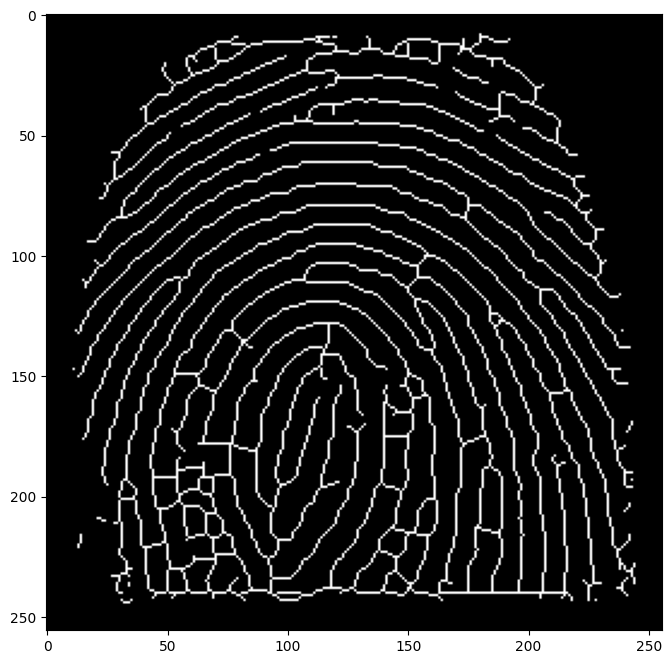

In [ ]:
def preprocess_skeleton(binary):
    # 스켈레톤화
    skeleton_img = skeletonize(binary // 150)
    skeleton_img = (skeleton_img * 255).astype(np.uint8)

    return skeleton_img

process_skel = preprocess_skeleton(bn)
plt.imshow(process_skel, cmap='gray')

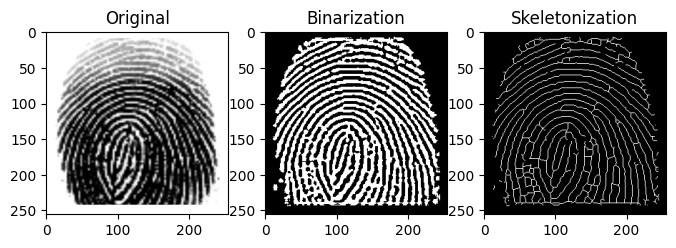

In [ ]:
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(img, cmap='gray')


plt.subplot(1, 3, 2)
plt.title('Binarization')
plt.imshow(bn, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Skeletonization')
plt.imshow(process_skel, cmap='gray')

### 특징 추출

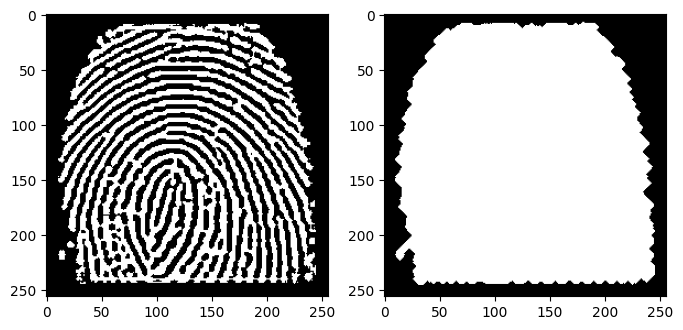

In [ ]:
def morph(binary_img):

    # 구조화 요소 커널, 사각형 (3x3) 생성 ---①
    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # 팽창 연산 적용 ---②
    dst = cv2.dilate(binary_img, k, iterations=1)

    # 닫힘 연산 적용 ---③
    closing = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, k, iterations=4)

    # # 열림 연산 적용 ---②
    # gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, k)

    # 열림 연산 적용 ---②
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, k, iterations=3)

    return opening


morph1 = morph(bn)

plt.subplot(1, 2, 1)
plt.imshow(bn, cmap='gray')


plt.subplot(1, 2, 2)
plt.imshow(morph1, cmap='gray')


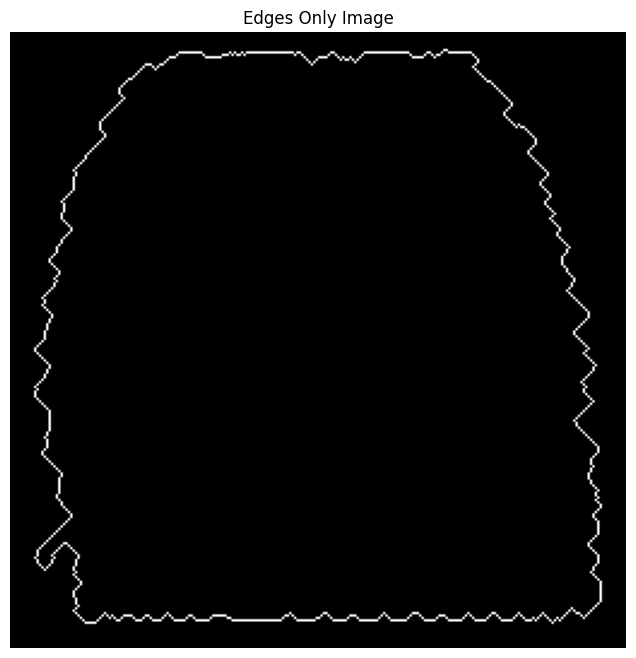

In [ ]:
def outline(morph):
    # 컨투어를 찾습니다.
    contours, _ = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 외곽선 이미지를 생성합니다.
    edges_only_image = np.zeros_like(morph.copy())

    # 컨투어를 외곽선 이미지에 그립니다.
    cv2.drawContours(edges_only_image, contours, -1, (255), thickness=1)

    return edges_only_image, contours

edges_only_image, contour_points = outline(morph1)

# 결과 이미지 표시
plt.imshow(edges_only_image, cmap='gray')
plt.title('Edges Only Image')
plt.axis('off')
plt.show()


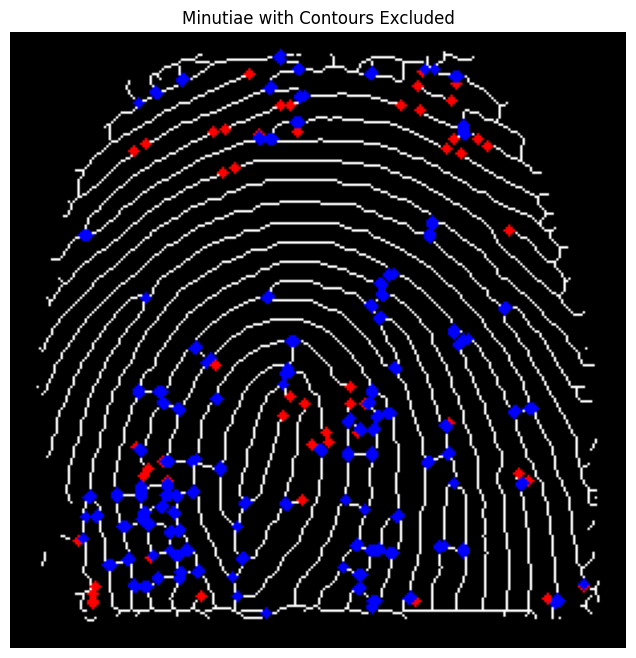

In [ ]:
# 특징점 추출

def minutiae_extraction(thinned_image, kernel_size):
    minutiae_endings = []
    minutiae_bifurcations = []
    rows, cols = thinned_image.shape
    k_half = kernel_size // 2

    # 이웃 픽셀 합계 계산
    for i in range(k_half, rows - k_half):
        for j in range(k_half, cols - k_half):
            if thinned_image[i, j] == 255:
                # 이웃 픽셀들의 합 계산
                neighbors = np.sum(thinned_image[i-1:i+2, j-1:j+2] == 255) - 1

                if neighbors == 1:
                    if not has_continuous_zeros(thinned_image, i, j):
                        minutiae_endings.append((j, i))
                elif neighbors == 3:
                    minutiae_bifurcations.append((j, i))

    return minutiae_endings, minutiae_bifurcations


def draw_minutiae(image, endpoints, bifurcations):
    image_with_minutiae = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    for endpoint in endpoints:
        cv2.circle(image_with_minutiae, endpoint, radius=2, color=(255, 0, 0), thickness=-1)
    for bifurcation in bifurcations:
        cv2.circle(image_with_minutiae, bifurcation, radius=2, color=(0, 0, 255), thickness=-1)
    return image_with_minutiae


def has_continuous_zeros(image, i, j):
    # Check if there are continuous 0s in 3x3 window
    window = image[i-1:i+2, j-1:j+2]
    return any(np.all(window[i:i+3] == 0) for i in range(len(window) - 2))

def remove_duplicate(minutiae, contours):
    # 컨투어에서 각각의 점 추출
    tuple_contours = [tuple(point.squeeze().tolist()) for contour in contours for point in contour]

    # 중복 제거를 위해 새로운 미누티아 리스트 생성
    unique_minutiae = []

    # 각 미누티아의 위치가 컨투어와 겹치는지 확인하고 중복 제거
    for m in minutiae:
        # 컨투어와 중복되지 않는 좌표 확인
        unique = True
        for contour_point in tuple_contours:
            if abs(m[0] - contour_point[0]) < 5 and abs(m[1] - contour_point[1]) < 5:
                unique = False
                break

        # 중복되지 않는 경우만 추가
        if unique:
            unique_minutiae.append(m)

    return unique_minutiae

def remove_duplicate_bif(minutiae_bifurcations, contours):
    # 컨투어에서 각각의 점 추출
    tuple_contours = [tuple(point.squeeze().tolist()) for contour in contours for point in contour]

    # 중복 제거를 위해 새로운 미누티아 리스트 생성
    unique_minutiae_bif = []

    # 각 미누티아의 위치가 컨투어와 겹치는지 확인하고 중복 제거
    for bif in minutiae_bifurcations:
        # 컨투어와 중복되지 않는 좌표 확인
        unique = True
        for contour_point in tuple_contours:
            if abs(bif[0] - contour_point[0]) < 10 and abs(bif[1] - contour_point[1]) < 10:
                unique = False
                break

        # 중복되지 않는 경우만 추가
        if unique:
            unique_minutiae_bif.append(bif)

    return unique_minutiae_bif


# Extract minutiae,
kernel_size = 3
minutiae_endings, minutiae_bifurcations = minutiae_extraction(process_skel.copy(), kernel_size)

# excluding contour points
unique_minutiae_endings = remove_duplicate(minutiae_endings, contour_points)
unique_minutiae_bif = remove_duplicate(minutiae_bifurcations, contour_points)

# minutiae on the skeleton image
image_with_minutiae = draw_minutiae(process_skel.copy(), unique_minutiae_endings, unique_minutiae_bif)


# Display the result
plt.imshow(image_with_minutiae)
plt.title('Minutiae with Contours Excluded')
plt.axis('off')
plt.show()


### 매칭

In [ ]:
# Initialize the best match variables
def processing_img(test_img_path, size=3):
    test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    temp = img_preprocessing(test_img,5)
    binarization_test = binarization(temp)
    morph_test = morph(binarization_test)
    edge_test, contour_test = outline(morph_test)
    skel_test = preprocess_skeleton(binarization_test)

    minutiae_endings_test, minutiae_bifurcations_test = minutiae_extraction(skel_test.copy(), kernel_size)

    # excluding contour points
    endings = remove_duplicate(minutiae_endings_test, contour_test)
    bifurcations = remove_duplicate(minutiae_bifurcations_test, contour_test)

    feature = np.concatenate([endings, bifurcations])

    return feature

In [ ]:
dic_train = {}

dic_test = {}

# test1에 가장 가까운 score을 sort

for path in tqdm(list_train):
    feature_train = processing_img(path, 3)
    dic_train[path] = np.array(feature_train)


for path in tqdm(list_test2):
    feature_test = processing_img(path, 3)
    dic_test[path] = np.array(feature_test)

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/1428 [00:00<?, ?it/s]

In [ ]:
# 파일명 추출
import os

def name_extraction(path):
  path_list = []
  for path in list_train:
    # 파일 이름 추출
    file_name = os.path.basename(path)

    path_list.append(file_name)

  return path_list


In [ ]:
# 두 점 사이의 유클리디언 거리를 계산하는 함수
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2, axis=1))

# 두 이미지의 특징점을 비교하여 매칭되는 특징점의 수와 총 거리 등을 계산하는 함수
def match_finger(test_features, train_features, threshold=4):
    matching_points = []
    total_distance = 0
    for tf in test_features:
        distances = euclidean_distance(tf, train_features)
        matches = np.where(distances < threshold)[0]
        for m in matches:
            matching_points.append((tf, train_features[m]))

    num_matches = len(matching_points)
    similarity = num_matches / ((len(test_features) + len(train_features)) / 2)
    return num_matches, similarity, matching_points

# 상위 N개의 매칭을 찾는 함수
def find_matching(train_features, test_features, top_n):
    match_results = []
    for test_path, feat_query in tqdm(test_features.items()):
        results = []
        for train_path, feat_train in train_features.items():
            num_matches, similarity, matching_points = match_finger(feat_query, feat_train, 4)
            results.append((train_path, similarity, num_matches))

        # Sort the results by similarity in descending order and get the top N
        results.sort(key=lambda x: x[1], reverse=True)
        top_matches = results[:top_n]

        print(f'Top {top_n} matches for {test_path}:')
        for match in top_matches:
            print(f'Train Path: {match[0]}, Similarity: {match[1]:.2f}, Number of Matches: {match[2]:.2f}')

        match_results.append((test_path, top_matches))

    # 평가 메트릭스 계산

    # tp = fp = tn = fn = 0
    # for test_path, top_matches in match_results:
    #     for match in top_matches:
    #         train_path, similarity, num_matches, dist = match
    #         if name_extraction[test_path] == name_extraction[train_path]:
    #             if similarity > 0.5:  # 임계값은 상황에 맞게 설정
    #                 tp += 1
    #             else:
    #                 fn += 1
    #         else:
    #             if similarity > 0.5:
    #                 fp += 1
    #             else:
    #                 tn += 1

    # precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # far = fp / (fp + tn) if (fp + tn) > 0 else 0
    # frr = fn / (fn + tp) if (fn + tp) > 0 else 0
    # accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    return match_results



In [ ]:
%%time
find_matching(dic_train, dic_test, 1)

  0%|          | 0/1428 [00:00<?, ?it/s]

Top 1 matches for /content/drive/MyDrive/생체/test2/test2/100_type1.BMP:
Train Path: /content/drive/MyDrive/생체/train/train_ref/100.BMP, Similarity: 2.35, Number of Matches: 599.00
Top 1 matches for /content/drive/MyDrive/생체/test2/test2/100_type2.BMP:
Train Path: /content/drive/MyDrive/생체/train/train_ref/100.BMP, Similarity: 1.89, Number of Matches: 540.00
Top 1 matches for /content/drive/MyDrive/생체/test2/test2/100_type3.BMP:
Train Path: /content/drive/MyDrive/생체/train/train_ref/100.BMP, Similarity: 2.36, Number of Matches: 626.00
Top 1 matches for /content/drive/MyDrive/생체/test2/test2/101_type1.BMP:
Train Path: /content/drive/MyDrive/생체/train/train_ref/101.BMP, Similarity: 2.43, Number of Matches: 855.00
Top 1 matches for /content/drive/MyDrive/생체/test2/test2/101_type2.BMP:
Train Path: /content/drive/MyDrive/생체/train/train_ref/101.BMP, Similarity: 2.53, Number of Matches: 977.00
Top 1 matches for /content/drive/MyDrive/생체/test2/test2/101_type3.BMP:
Train 

[('/content/drive/MyDrive/생체/test2/test2/100_type1.BMP',
  [('/content/drive/MyDrive/생체/train/train_ref/100.BMP',
    2.3536345776031435,
    599)]),
 ('/content/drive/MyDrive/생체/test2/test2/100_type2.BMP',
  [('/content/drive/MyDrive/생체/train/train_ref/100.BMP',
    1.8881118881118881,
    540)]),
 ('/content/drive/MyDrive/생체/test2/test2/100_type3.BMP',
  [('/content/drive/MyDrive/생체/train/train_ref/100.BMP',
    2.3578154425612055,
    626)]),
 ('/content/drive/MyDrive/생체/test2/test2/101_type1.BMP',
  [('/content/drive/MyDrive/생체/train/train_ref/101.BMP',
    2.4324324324324325,
    855)]),
 ('/content/drive/MyDrive/생체/test2/test2/101_type2.BMP',
  [('/content/drive/MyDrive/생체/train/train_ref/101.BMP',
    2.5278137128072444,
    977)]),
 ('/content/drive/MyDrive/생체/test2/test2/101_type3.BMP',
  [('/content/drive/MyDrive/생체/train/train_ref/101.BMP',
    2.8715728715728717,
    995)]),
 ('/content/drive/MyDrive/생체/test2/test2/102_type1.BMP',
  [(